In [24]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [25]:
!pip install pycm

In [26]:
import time
import os
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import interpolate
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
import scipy.sparse
import sys
import pickle
import re
from scipy import stats
from numpy import savetxt
from numpy import genfromtxt
import networkx as nx
from scipy.stats import norm
import itertools
import math
import copy
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.metrics import confusion_matrix
from pycm import *

In [27]:
def conditional_mutual_info(X,Y,Z=np.array(1)):
    
    if X.ndim == 1:
            X = np.reshape(X, (-1, 1))
    
    if Y.ndim == 1:
            Y = np.reshape(Y, (-1, 1))
            
    if Z.ndim == 0: 
        c1 = np.cov(X)
        
        if c1.ndim != 0: 
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()
            
        c2 = np.cov(Y)
        
        if c2.ndim != 0: 
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()
            
        c3 = np.cov(X,Y)
        
        if c3.ndim != 0: 
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()
            
        cmi = (1/2)*np.log((d1*d2)/d3)
    
    else:
        
        if Z.ndim == 1:
            Z = np.reshape(Z, (-1, 1))
        
        c1 = np.cov(np.concatenate((X, Z), axis=0))
        
        if c1.ndim != 0: 
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()
    
        c2 = np.cov(np.concatenate((Y, Z), axis=0))
        
        if c2.ndim != 0: 
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()
            
        c3 = np.cov(Z)
        
        if c3.ndim != 0: 
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()
            
        c4 = np.cov(np.concatenate((X, Y, Z), axis=0))
        
        if c4.ndim != 0: 
            d4 = np.linalg.det(c4)
        else:
            d4 = c4.item()
        
        cmi = (1/2)*np.log((d1*d2)/(d3*d4))
    
    
    if math.isinf(cmi):
        cmi = 0
    
    return cmi



In [28]:
def pca_cmi(data, theta, max_order,filename):
    
    genes = list(data.columns)
    
    predicted_graph = nx.complete_graph(genes)
    num_edges = predicted_graph.number_of_edges()
    
    L = -1
    nochange = False
    
    while L < max_order and nochange == False:
        L = L+1
        predicted_graph, nochange = remove_edges(predicted_graph, data, L, theta)
    
    
    print()
    print()
    print("Final Prediction:")
    print("-----------------")
    print("Order : {}".format(L))
    print("Number of edges in the predicted graph : {}".format(predicted_graph.number_of_edges()))

    f = plt.figure()
    nx.draw(predicted_graph, with_labels=True, font_weight='bold')
    plt.savefig('/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Results/Size50/Undirected_'+filename+'_'+str(theta)+'.png')
    plt.show()

    print()
    return predicted_graph


def remove_edges(predicted_graph, data, L, theta):
    
    initial_num_edges = predicted_graph.number_of_edges()
    
    edges = predicted_graph.edges()

    for edge in edges:
        neighbors = nx.common_neighbors(predicted_graph, edge[0], edge[1])
        nhbrs = copy.deepcopy(sorted(neighbors))
        
        T = len(nhbrs)
        
        if T < L and L != 0:
            continue
        
        else:
            x = data[edge[0]].to_numpy()
            if x.ndim == 1:
                x = np.reshape(x, (-1, 1))
            
            y = data[edge[1]].to_numpy()
            if y.ndim == 1:
                y = np.reshape(y, (-1, 1))
                
            K = list(itertools.combinations(nhbrs, L))
                
            if L == 0:
                cmiVal = conditional_mutual_info(x.T, y.T)
                
                if cmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])
                               
            else:  
                
                maxCmiVal = 0
                
                for zgroup in K:
                    
                    z = data[list(zgroup)].to_numpy()
                    if z.ndim == 1:
                        z = np.reshape(z, (-1, 1))
                    
                    cmiVal = conditional_mutual_info(x.T, y.T, z.T)
                    
                    if cmiVal > maxCmiVal:
                        maxCmiVal = cmiVal
                
                if maxCmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])
                    
                
        
    final_num_edges = predicted_graph.number_of_edges()
        
    if final_num_edges < initial_num_edges:
        return  predicted_graph, False
        
        
    return  predicted_graph, True
            

In [29]:
def get_chains(graph):
    
    adj_list = nx.generate_adjlist(graph, delimiter=" ")
    
    mapping = {}
    for idx,line in enumerate(adj_list):
        line = line.split(" ")
        mapping[line[0]] = set(line[1:])
    
    for element in mapping:
        for adjacent_element in mapping[element]:
            mapping[adjacent_element].add(element)
    
    triples = []
    
    for element in mapping:
        for adjacent_element in mapping[element]:
            for adj_adj_element in mapping[adjacent_element]:
                if adj_adj_element != element:
                    triple = [element, adjacent_element, adj_adj_element]
                    triples.append(triple)
                
    return triples


In [30]:
def forms_v_shape(adjMatrix, point1, point2):
    length = adjMatrix.shape[0]
    
    for i in range(0,length):
        if adjMatrix[i][point2] == 1 and adjMatrix[point2][i] == 0 and i != point1:
            return True
    
    return False

In [31]:
def forms_cycle(adjMatrix, point1, point2):
    
    len = adjMatrix.shape[0]
    
    for i in range(0,len):
        for j in range(0,len):
            if adjMatrix[i][j] == 1 and adjMatrix[j][i] == 1:
                adjMatrix[i][j] = 0
                adjMatrix[j][i] = 0
                
    adjMatrix[point1][point2] = 1
    adjMatrix[point2][point1] = 0
    
    G = nx.from_numpy_matrix(adjMatrix,create_using=nx.DiGraph)
    
    return not(nx.is_directed_acyclic_graph(G))

In [32]:
def align_edges(graph, data, theta):
    
    num_nodes = graph.number_of_nodes()
    directed_graph = nx.to_numpy_array(graph)

    #Step 1: Align the v-structure
    
    mapping = {}
    for i in range(0,num_nodes):
        mapping[i] = 'G'+str(i+1)
    
    non_edge_pairs = list(nx.non_edges(graph))
    
    for non_edge in non_edge_pairs:
        common_neighbors = sorted(nx.common_neighbors(graph, non_edge[0], non_edge[1]))
        
        x = data[non_edge[0]].to_numpy()
        if x.ndim == 1:
            x = np.reshape(x, (-1, 1))
        y = data[non_edge[1]].to_numpy()
        if y.ndim == 1:
            y = np.reshape(y, (-1, 1))
                
        for neighbor in common_neighbors:
            
            z = data[neighbor].to_numpy()
            if z.ndim == 1:
                z = np.reshape(z, (-1, 1))
                
            cmiVal = conditional_mutual_info(x.T, y.T, z.T)
            
            xind = data.columns.get_loc(non_edge[0])
            yind = data.columns.get_loc(non_edge[1])
            zind = data.columns.get_loc(neighbor)
                
            if directed_graph[xind][zind] == 1 and directed_graph[zind][xind] == 1 and directed_graph[yind][zind] == 1 and directed_graph[zind][yind] == 1:
                if not cmiVal < theta:
                    directed_graph[xind][zind] = 1
                    directed_graph[zind][xind] = 0
                    directed_graph[yind][zind] = 1
                    directed_graph[zind][yind] = 0
    
    
    # Step 2: Use Rule 1 of edge alignments to orient edges a -> b - c to a -> b -> c if adding the edge does not form a cycle or v-structure
    
    triples = get_chains(graph)
    
    for triple in triples:
        xind = data.columns.get_loc(triple[0])
        yind = data.columns.get_loc(triple[1])
        zind = data.columns.get_loc(triple[2])
        
        if directed_graph[xind][zind] == 0 and directed_graph[zind][xind] == 0 :
            frozen_graph = np.copy(directed_graph)
            forms_v = forms_v_shape(frozen_graph, yind, zind)
            forms_cyc = forms_cycle(frozen_graph, yind, zind)

            if not ( forms_v or forms_cyc ):
                if directed_graph[xind][yind] == 1 and directed_graph[yind][xind] == 0 and directed_graph[yind][zind] == 1 and directed_graph[zind][yind] == 1:
                    directed_graph[yind][zind] = 1
                    directed_graph[zind][yind] = 0

    
    # Step 3: Use Rule 2 of edge alignments to orient edges that form a cycle if oriented the other way.
   
    frozen_graph = np.copy(directed_graph)
    for i in range(0,num_nodes):
        for j in range(0,num_nodes):
            if frozen_graph[i][j] == 1 and frozen_graph[j][i] == 1:
                if forms_cycle(frozen_graph, i, j) and not(forms_cycle(frozen_graph, j, i)):
                    directed_graph[j][i] = 1
                    directed_graph[i][j] = 0
        
    G = nx.from_numpy_matrix(directed_graph,create_using=nx.DiGraph)
    G = nx.relabel_nodes(G, mapping)

    return G

    

In [33]:
def print_theta_accuracy(standardnw_path,dataset_path,filename):

  theta_list = [0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]
  acc_value = []
  acc_dir_value = []
  data = pd.read_csv(dataset_path, sep='\t') 
  data = data.iloc[: , 1:]

  #getting benchmark data from file
  benchmark_network = pd.read_csv(standardnw_path, sep='\t', header=None)
  benchmark_network = benchmark_network.loc[benchmark_network[2] == 1]

  #creating benchmark graph and matrix
  benchmark_graph = nx.Graph()

  for i in (1,50):
      benchmark_graph.add_node('G'+str(i))
  print(benchmark_network.shape)
  for row in range(0,benchmark_network.shape[0]):
      benchmark_graph.add_edge(benchmark_network[0][row], benchmark_network[1][row])


  #creating benchmark directed graph and matrix
  benchmark_directed_graph = nx.DiGraph()

  for i in (1,10):
      benchmark_directed_graph.add_node('G'+str(i))
  print(benchmark_network.shape)
  for row in range(0,benchmark_network.shape[0]):
      benchmark_directed_graph.add_edge(benchmark_network[0][row], benchmark_network[1][row])


  benchmark_adjMatrix = nx.adjacency_matrix(benchmark_graph)
  benchmark_dir_adjMatrix = nx.adjacency_matrix(benchmark_directed_graph)



  for i in theta_list:
    predicted_graph = pca_cmi(data, i, 20, filename)
    predicted_adjMatrix = nx.adjacency_matrix(predicted_graph)
    predicted_dir_graph = align_edges(predicted_graph, data, i)
    predicted_dir_adjMatrix = nx.adjacency_matrix(predicted_dir_graph)

    y_test = benchmark_adjMatrix.todense().flatten()
    y_pred = predicted_adjMatrix.todense().flatten()

    y_test_dir = benchmark_dir_adjMatrix.todense().flatten()
    y_pred_dir = predicted_dir_adjMatrix.todense().flatten()

    y_pred_dir = y_pred_dir.astype(int)

    y_pred = np.asarray(y_pred)
    y_test = np.asarray(y_test)

    y_pred_dir = np.asarray(y_pred_dir)
    y_test_dir = np.asarray(y_test_dir)

    y_pred = y_pred.reshape(y_pred.shape[1],)
    y_test = y_test.reshape(y_test.shape[1],)

    y_pred_dir = y_pred_dir.reshape(y_pred_dir.shape[1],)
    y_test_dir = y_test_dir.reshape(y_test_dir.shape[1],)

    cm = ConfusionMatrix(y_test, y_pred)
    cm_dir = ConfusionMatrix(y_test_dir, y_pred_dir)

    ns_fpr, ns_tpr, _ = roc_curve(y_test, y_pred)

    auc = roc_auc_score(y_test, y_pred)

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, label='AUC='+str(round(auc*100,2))+'%')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend(loc = 5)
    plt.savefig('/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Results/Size50/AUC_'+filename+'_'+str(i)+'.png')

    plt.show()

    temp_l = [cm.ACC_Macro, cm.F1_Macro, cm.TPR_Macro, cm.FPR_Macro]
    temp_l = [round(num, 2) for num in temp_l]
    acc_value.append(temp_l)

    temp_l = [cm_dir.ACC_Macro, cm_dir.F1_Macro, cm_dir.TPR_Macro, cm_dir.FPR_Macro]
    acc_dir_value.append(temp_l)
  
  return theta_list, acc_value, acc_dir_value;



In [34]:
directory = '/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Size50/DREAM3 data/'
df_index = []
for filename in os.listdir(directory):
  if('Yeast' in filename or 'Ecoli' in filename):
    split_filename = (filename.split('-'))
  
    if(split_filename[2] in ['null','nonoise'] ):
      type = split_filename[3].split('.')
      split_mix = split_filename[2]+'-'+type[0]
    else:
      type = split_filename[2].split('.')
      split_mix = type[0]

    df_index.append(split_filename[1]+'-'+split_mix)

df_columns = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

# print(len(set(df_index)))
result_df = pd.DataFrame(columns=df_columns, index=df_index)
directed_result_df = pd.DataFrame(columns=df_columns, index=df_index)

In [35]:
result_df.shape

(25, 8)

/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Size50/DREAM3 data/InSilicoSize50-Ecoli1-null-mutants.tsv
(62, 3)
(62, 3)


Final Prediction:
-----------------
Order : 5
Number of edges in the predicted graph : 113


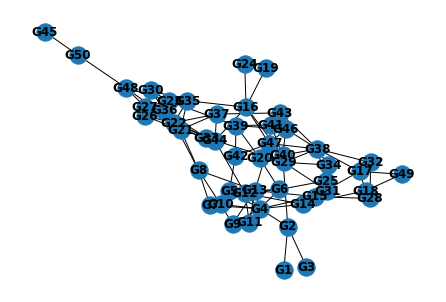

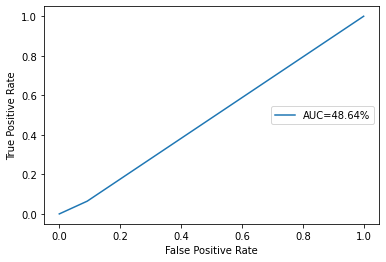



Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 89


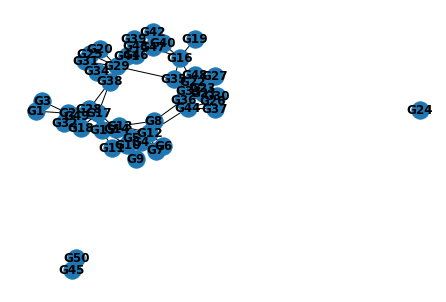

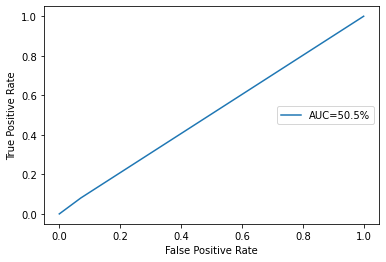



Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 79


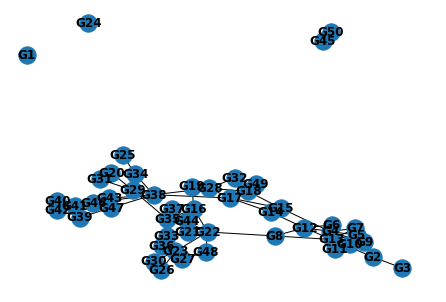

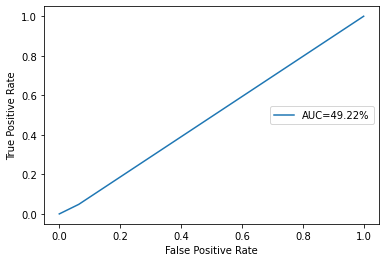



Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 69


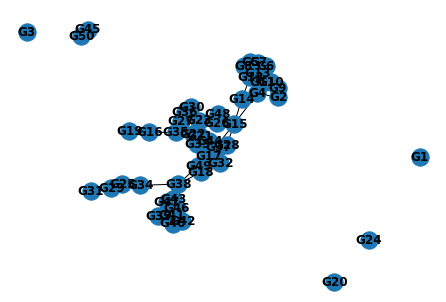

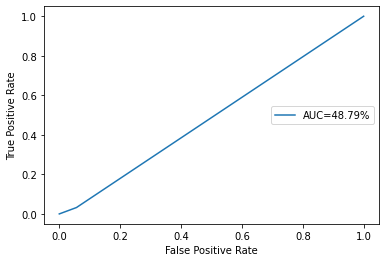



Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 59


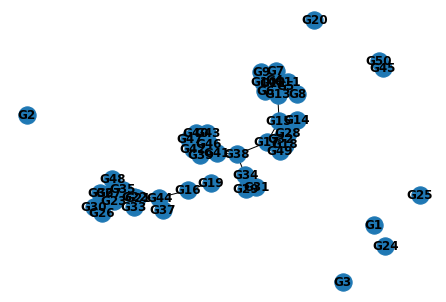

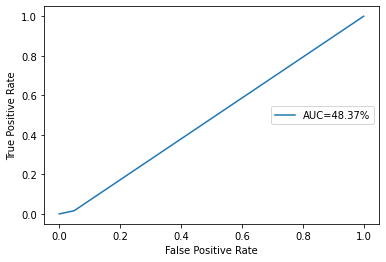



Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 55


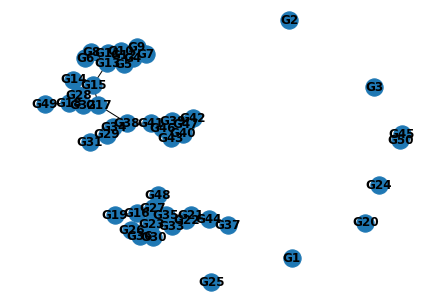

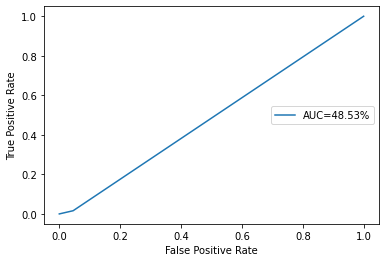



Final Prediction:
-----------------
Order : 3
Number of edges in the predicted graph : 48


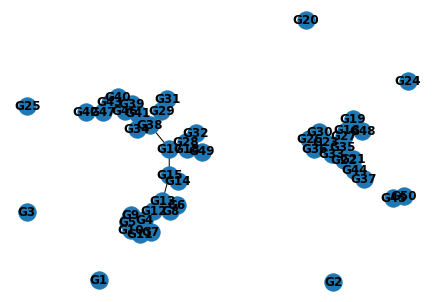

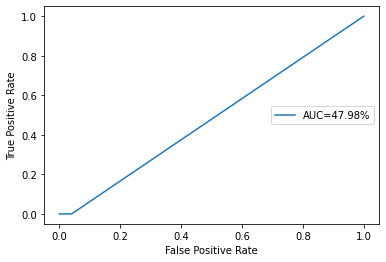



Final Prediction:
-----------------
Order : 3
Number of edges in the predicted graph : 48


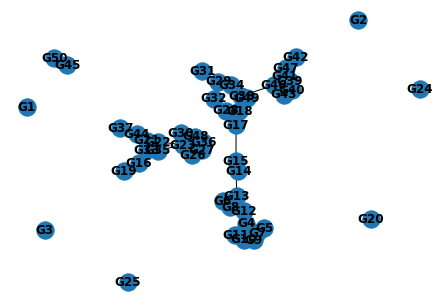

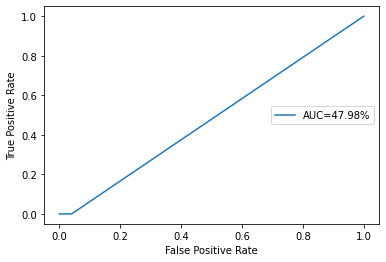

/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Size50/DREAM3 data/InSilicoSize50-Ecoli1-nonoise-heterozygous.tsv
(62, 3)
(62, 3)


Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 29


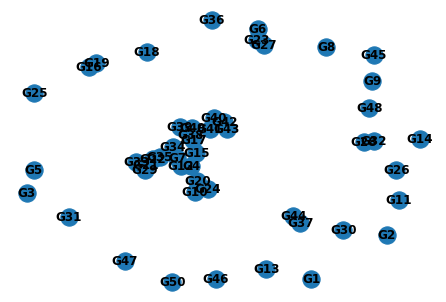

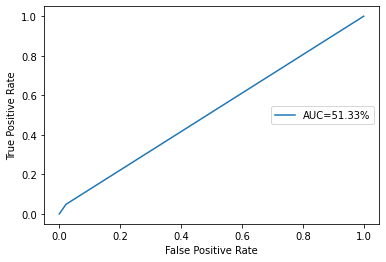



Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 25


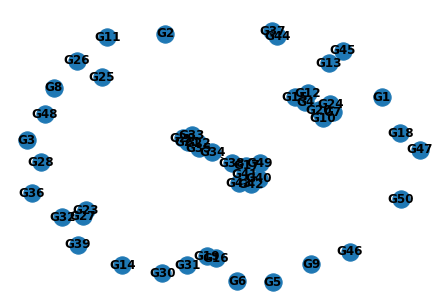

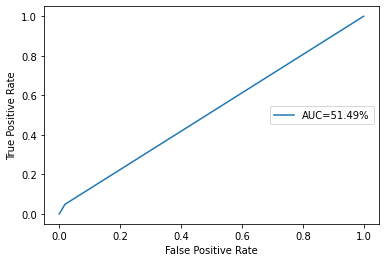



Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 21


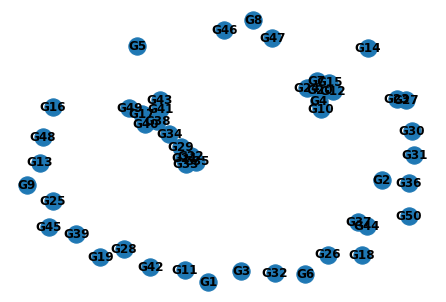

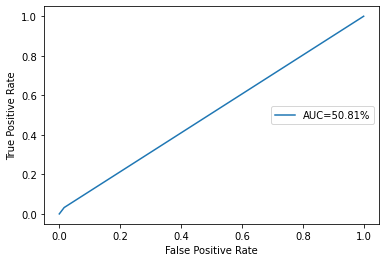



Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 18


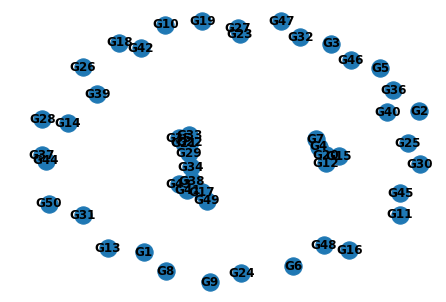

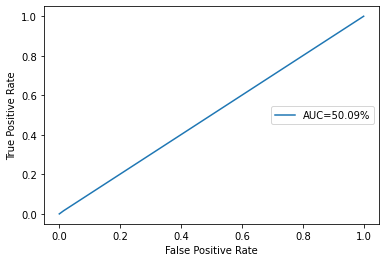



Final Prediction:
-----------------
Order : 3
Number of edges in the predicted graph : 17


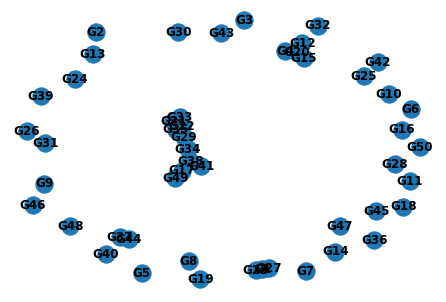

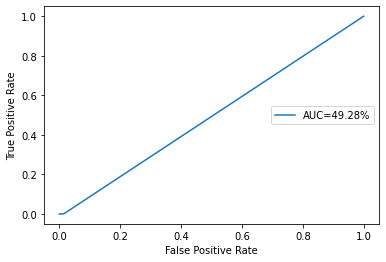



Final Prediction:
-----------------
Order : 3
Number of edges in the predicted graph : 14


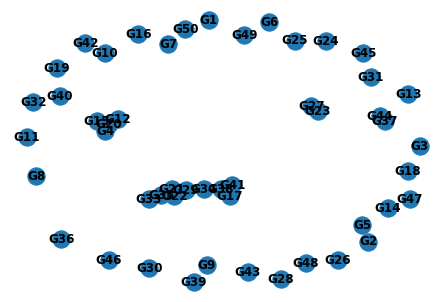

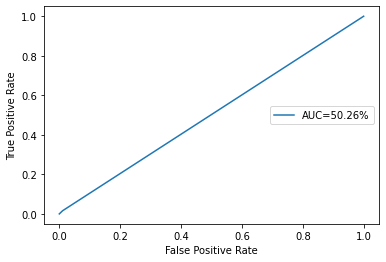



Final Prediction:
-----------------
Order : 3
Number of edges in the predicted graph : 13


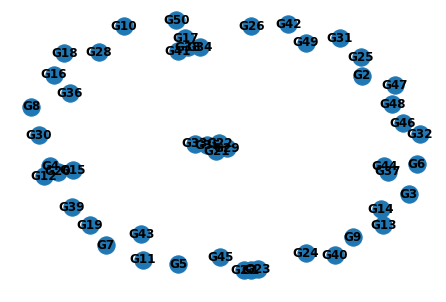

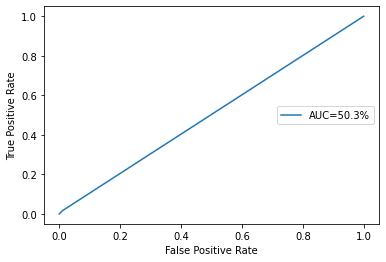



Final Prediction:
-----------------
Order : 3
Number of edges in the predicted graph : 13


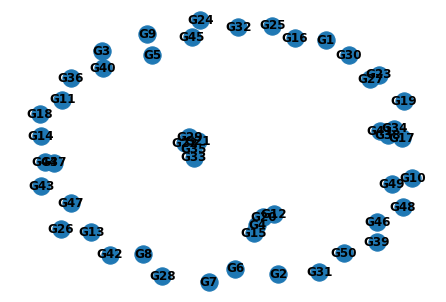

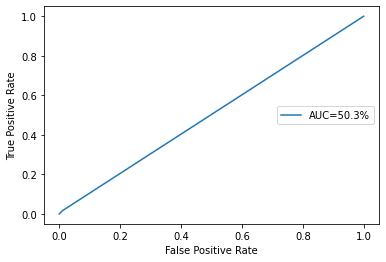

/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Size50/DREAM3 data/InSilicoSize50-Ecoli1-nonoise-proteins-heterozygous.tsv
(62, 3)
(62, 3)


Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 29


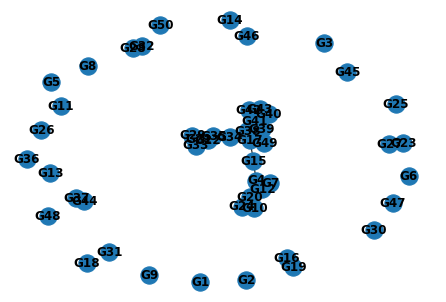

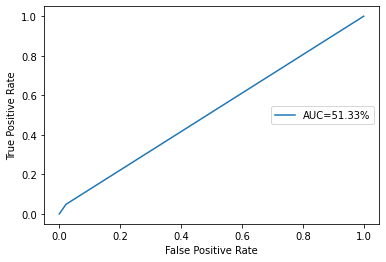



Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 25


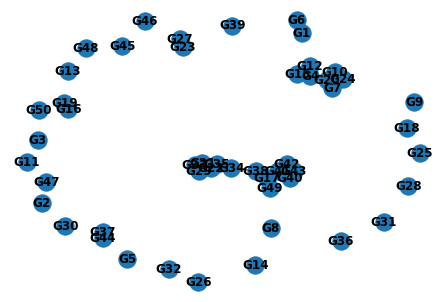

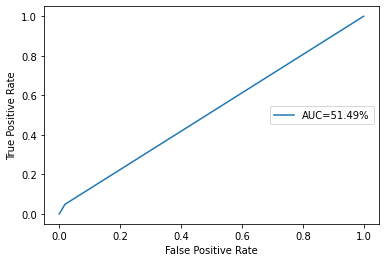



Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 21


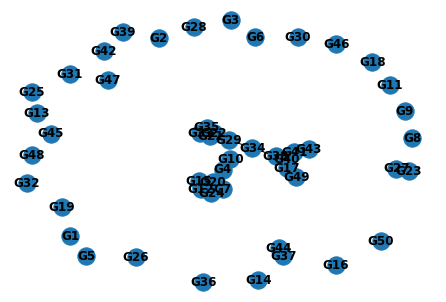

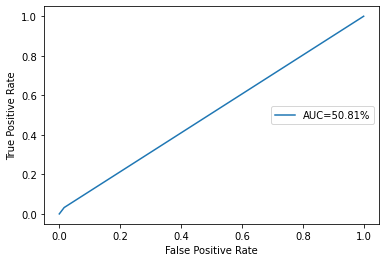



Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 18


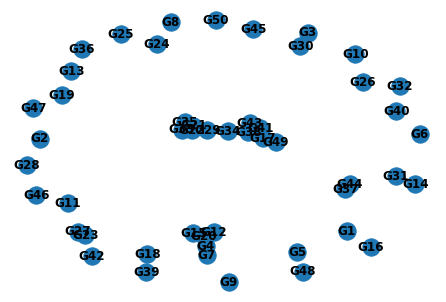

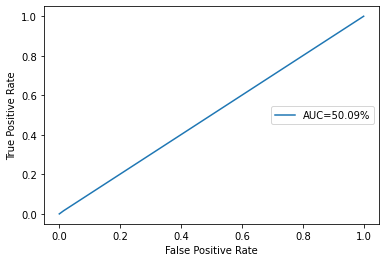



Final Prediction:
-----------------
Order : 3
Number of edges in the predicted graph : 17


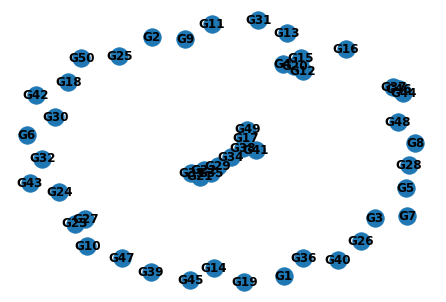

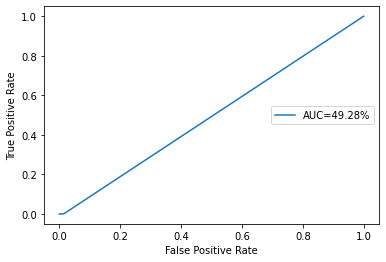



Final Prediction:
-----------------
Order : 3
Number of edges in the predicted graph : 14


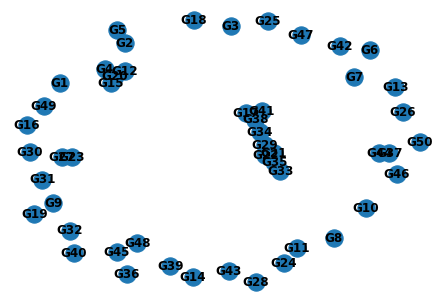

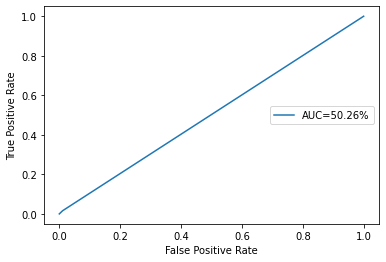



Final Prediction:
-----------------
Order : 3
Number of edges in the predicted graph : 13


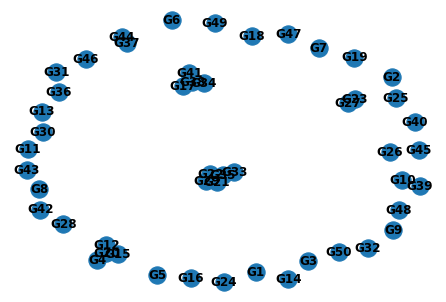

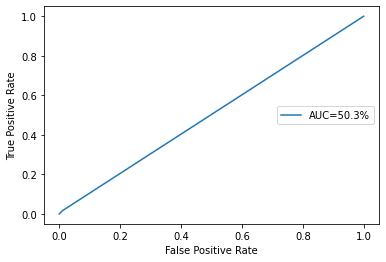



Final Prediction:
-----------------
Order : 3
Number of edges in the predicted graph : 13


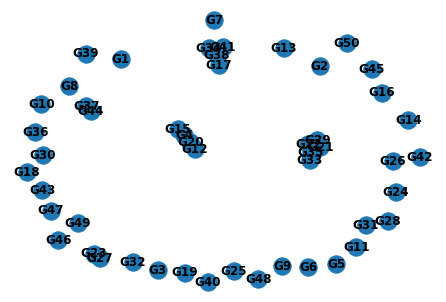

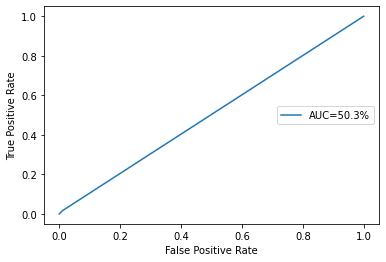

/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Size50/DREAM3 data/InSilicoSize50-Ecoli1-trajectories.tsv
(62, 3)
(62, 3)


In [ ]:

directory = '/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Size50/DREAM3 data/'
goldstandard_path = '/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Size50/DREAM3 gold standards/'


for filename in os.listdir(directory):
  if('Yeast' in filename or 'Ecoli' in filename):
    dataset_path = directory+filename
    split_filename = (filename.split('-'))

    if(split_filename[2] in ['null','nonoise']):
      type = split_filename[3].split('.')
      split_mix = split_filename[2]+'-'+type[0]
    else:
      type = split_filename[2].split('.')
      split_mix = type[0]

    index_location = split_filename[1]+'-'+split_mix

    goldstandard_name = ('DREAM3GoldStandard_'+split_filename[0]+'_'+split_filename[1]+'.txt')
    standardnw_path = goldstandard_path+goldstandard_name
    print(dataset_path)
    theta_list, acc_value, acc_dir_value = print_theta_accuracy(standardnw_path,dataset_path, filename)

    for i in range(0, len(theta_list)):
      result_df[theta_list[i]][index_location] = "ACC="+str(acc_value[i][0])+" , F1="+str(acc_value[i][1])+" , TPR="+str(acc_value[i][2])+" , FPR="+str(acc_value[i][3])
      directed_result_df[theta_list[i]][index_location] = "ACC="+str(acc_dir_value[i][0])+" , F1="+str(acc_dir_value[i][1])+" , TPR="+str(acc_dir_value[i][2])+" , FPR="+str(acc_dir_value[i][3])
    
    result_df.to_csv('/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Results/Size50/results50_skeleton_only.csv')
    directed_result_df.to_csv('/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Results/Size50/results50_edge_oriented.csv')


In [ ]:
result_df